In [1]:
import sys
import importlib
import Monty
import Hmm
import numpy as np
import time
import pandas as pd
import datetime

In [2]:
# import importlib
# importlib.reload(Monty)
from Monty import SimRSDC
from Hmm import Base

univariate_parameters = np.array([[0.05, 0.15, 0.75],
                      [0.2, 0.3, 0.65]])
true_correlation_matrix = np.array([[[1, 0.7],[0.7,1]],[[1, -0.6],[-0.6, 1]]])

# univariate_parameters = np.array([[0.05, 0.15, 0.75],
#                       [0.1, 0.25, 0.6],
#                       [0.15, 0.15, 0.8],
#                       [0.2, 0.3, 0.65]])
# true_correlation_matrix = np.array([
#     # High correlations
#     [[1, 0.8, 0.7, 0.6],
#      [0.8, 1, 0.65, 0.55],
#      [0.7, 0.65, 1, 0.5],
#      [0.6, 0.55, 0.5, 1]],
    
#     # # Low correlations
#     # [[1, 0.1, 0.15, 0.05],
#     #  [0.1, 1, 0.2, 0.1],
#     #  [0.15, 0.2, 1, 0.12],
#     #  [0.05, 0.1, 0.12, 1]],
    
#     # Negative correlations
#     [[1, -0.5, -0.4, -0.3],
#      [-0.5, 1, -0.2, -0.1],
#      [-0.4, -0.2, 1, -0.25],
#      [-0.3, -0.1, -0.25, 1]],
    
#     # # In between
#     # [[1, 0.4, -0.3, 0.2],
#     #  [0.4, 1, 0.25, -0.2],
#     #  [-0.3, 0.25, 1, 0.15],
#     #  [0.2, -0.2, 0.15, 1]]
# ])
print(univariate_parameters[:,0])
sim = SimRSDC(transition_diagonal=0.995, num_obs=5000, K_series=2, rho=true_correlation_matrix, omega=univariate_parameters[:,0], alpha=univariate_parameters[:,1], beta=univariate_parameters[:,2] )
sim.simulate()
print(sim.rho_matrix)
sim.full_df, sim.transition_matrix

[0.05 0.2 ]
[[[ 1.   0.7]
  [ 0.7  1. ]]

 [[ 1.  -0.6]
  [-0.6  1. ]]]


(      States  Returns 0  Returns 1
 0        0.0   0.000000   0.000000
 1        0.0  -0.795088  -1.732843
 2        0.0  -1.135735  -1.546627
 3        0.0   0.796524   2.936108
 4        0.0   1.610985   2.896909
 ...      ...        ...        ...
 4995     1.0  -0.606263   0.604711
 4996     1.0  -1.300086   2.312195
 4997     1.0  -1.183792   1.981384
 4998     1.0  -0.229601   1.708739
 4999     1.0  -0.364868  -0.676653
 
 [5000 rows x 3 columns],
 array([[0.995, 0.005],
        [0.005, 0.995]]))

In [3]:
sim.correlation_matrix

model = Base(sim.data, univariate_parameters=univariate_parameters)
model.fit()
# print(model.transition_matrix)
# model.e_step()
# print(model.v_hat)
# model.m_step()

# model.get_densities()
# # Forward 
# model.forward_pass()
# # Backward 
# model.backward_pass()
# # Smoothed 
# model.calculate_smoothed_probabilities()

# model.estimate_transition_matrix()
# model.transition_matrix

# model.plot_true_smoothed(sim.full_df)
# # model.plot_smoothed_probabilities()
# model.plot_histories()

In [4]:
importlib.reload(Hmm)
from Hmm import Base

model.numeric_corr()

In [5]:
model.new_correlation_matrix

array([[[ 1.        , -0.60186441],
        [-0.60186441,  1.        ]],

       [[ 1.        ,  0.70247057],
        [ 0.70247057,  1.        ]]])

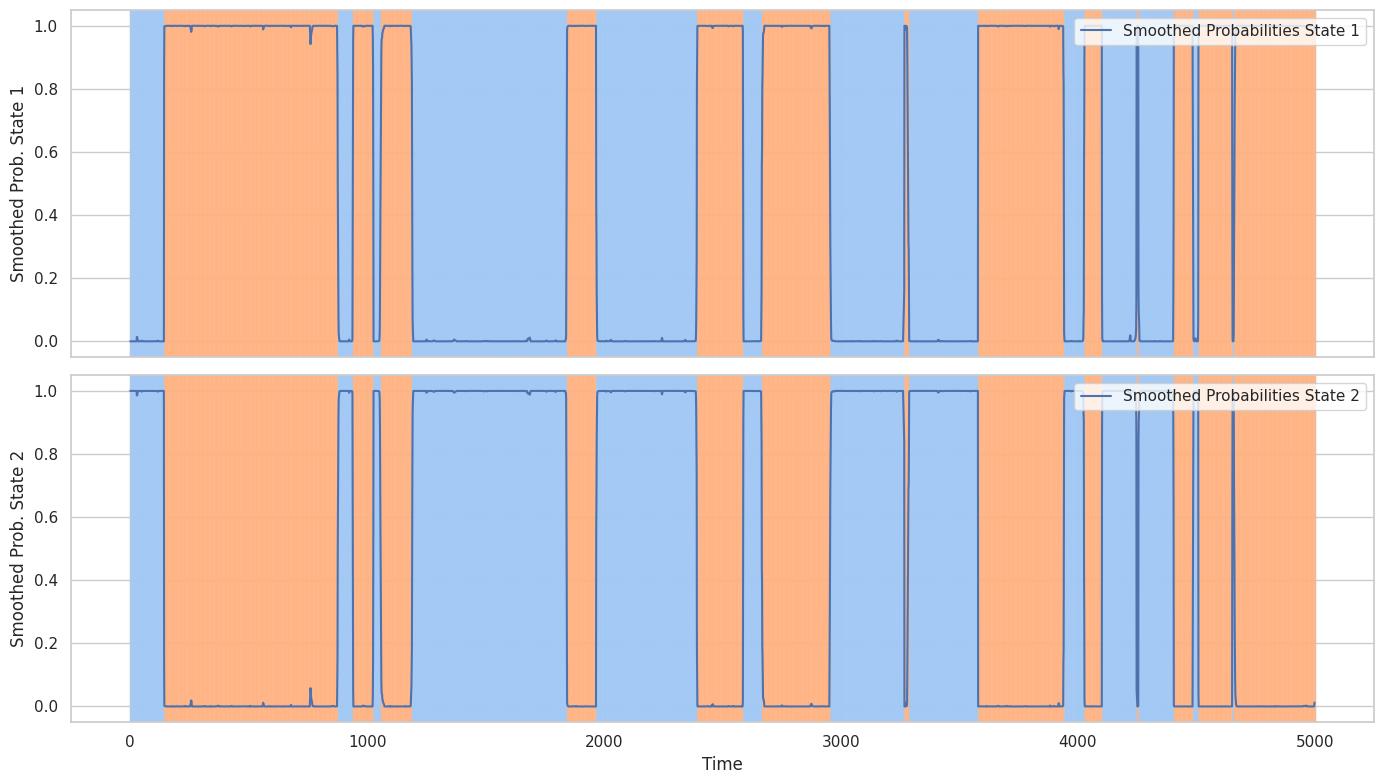

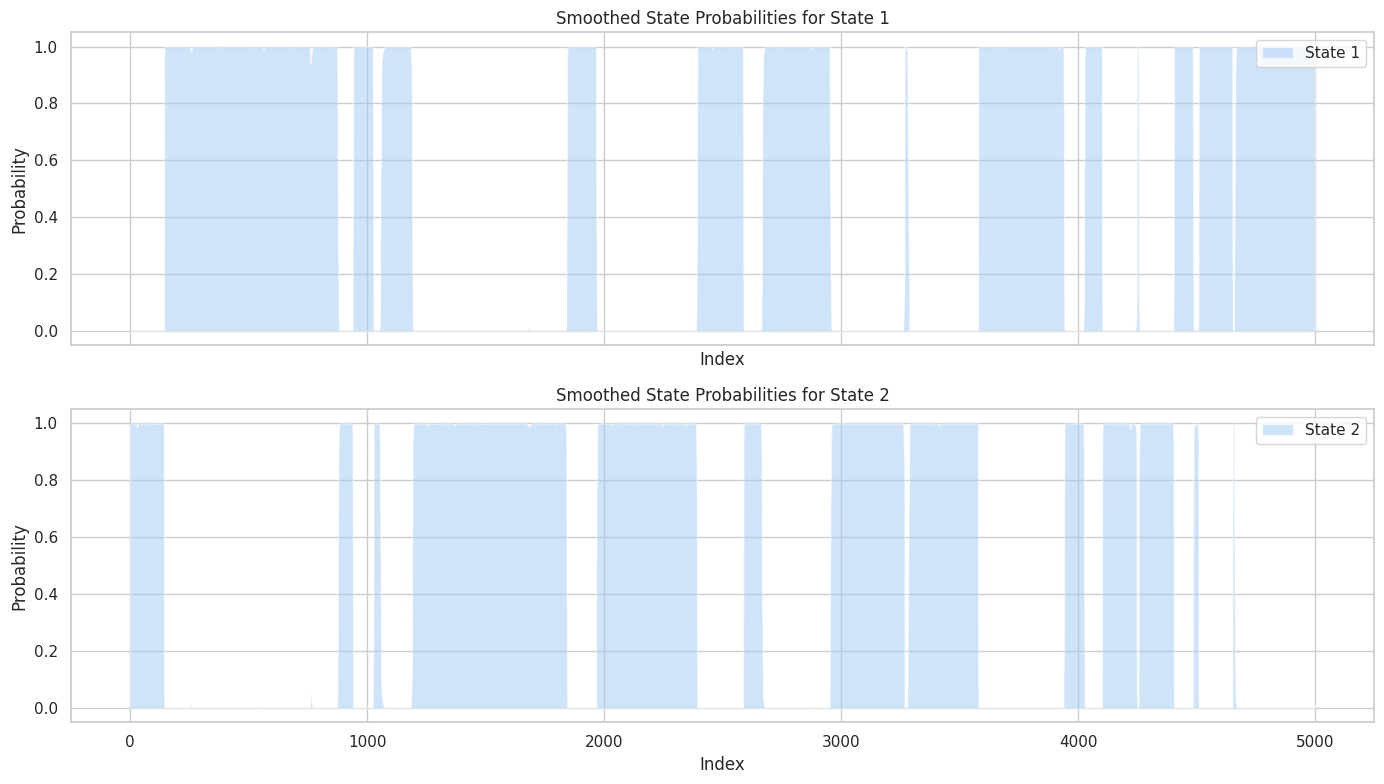

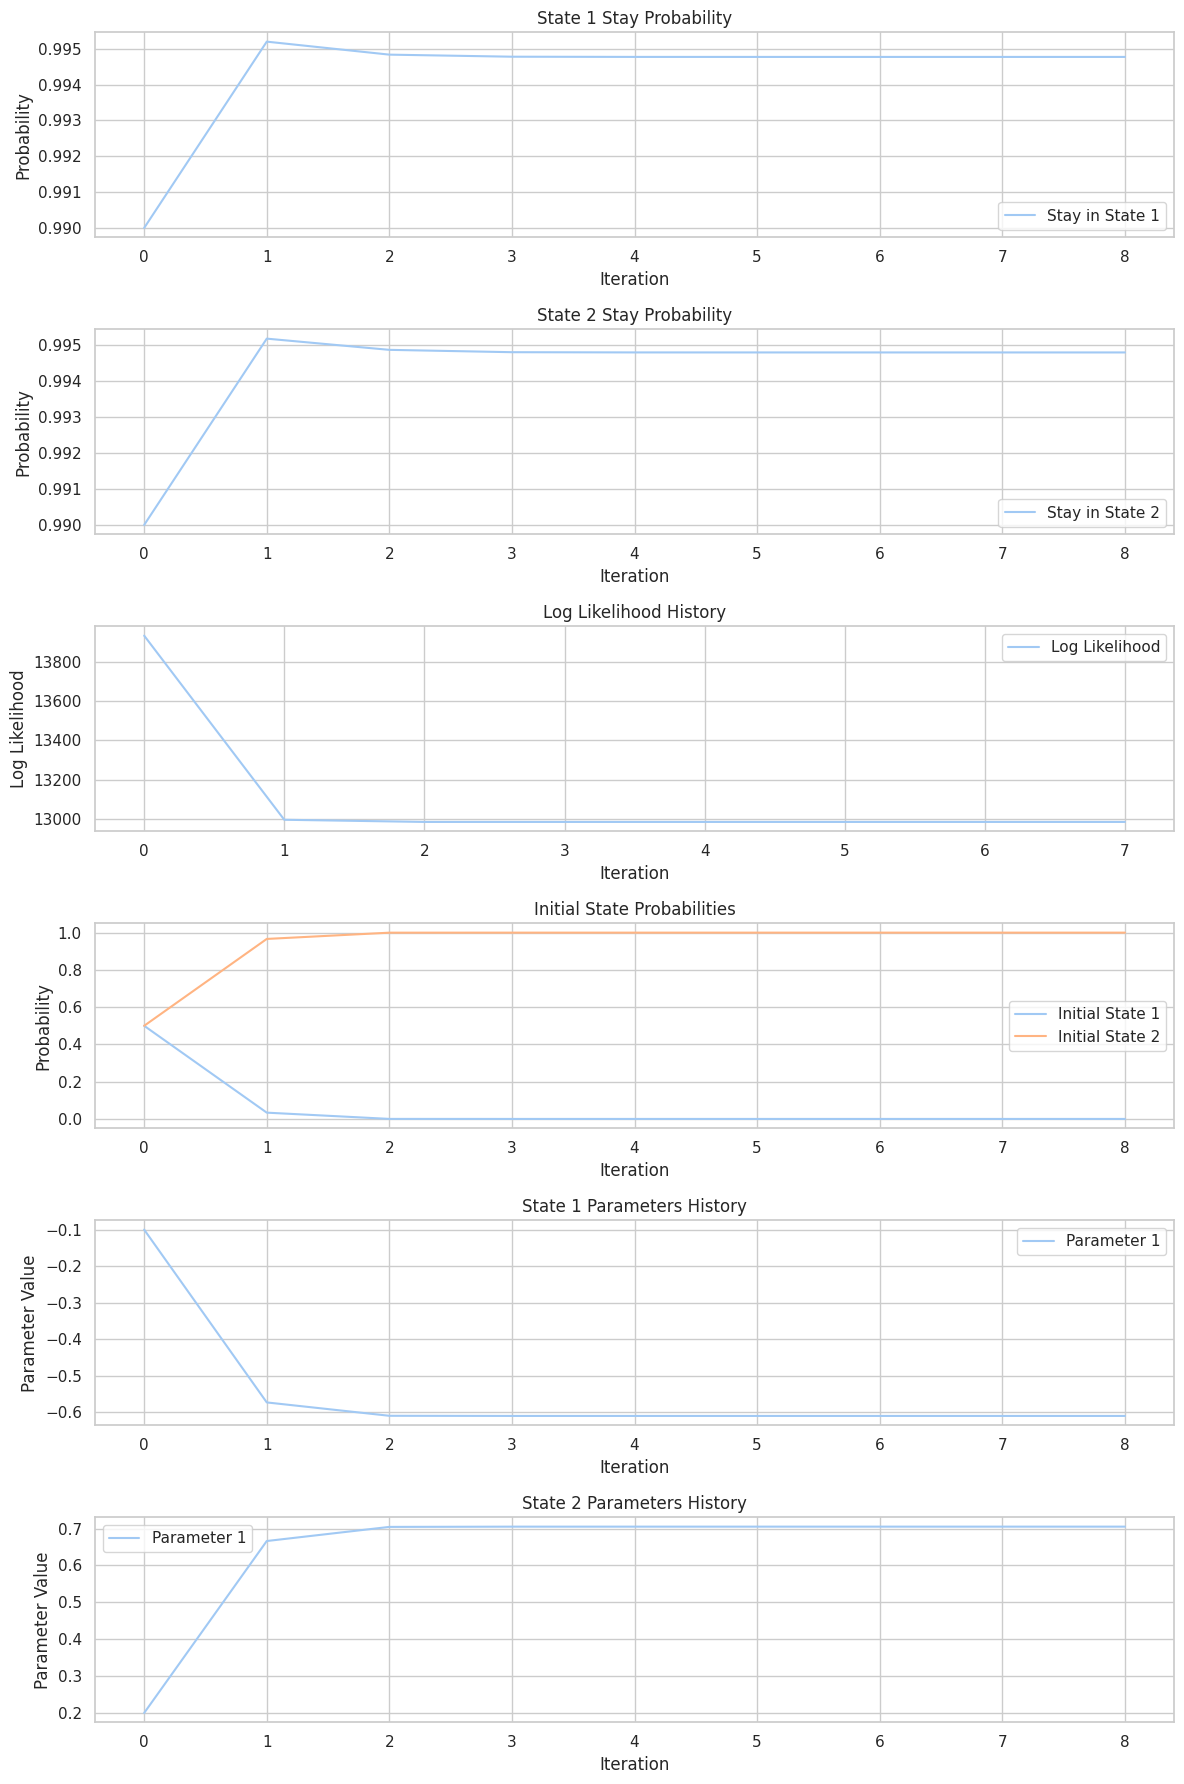

In [6]:
model.plot_true_smoothed(sim.full_df)
model.plot_smoothed_probabilities()
model.plot_histories()

In [7]:
model.correlation_matrix

array([[[ 1.        , -0.60969185],
        [-0.60969185,  1.        ]],

       [[ 1.        ,  0.70517652],
        [ 0.70517652,  1.        ]]])

In [8]:
sim.correlation_matrix

array([[[ 1. ,  0.7],
        [ 0.7,  1. ]],

       [[ 1. , -0.6],
        [-0.6,  1. ]]])

In [9]:
model.transition_matrix - sim.transition_matrix

array([[-0.00023036,  0.00023036],
       [ 0.00020722, -0.00020722]])

In [10]:
from scipy.optimize import linear_sum_assignment

def match_and_subtract(sim, est):
    """
    Matches simulated and estimated correlation matrices across states to minimize error,
    and returns the differences between matched estimated and simulated matrices.
    
    Parameters:
    - sim: np.array with dimensions (n_states, K, K), simulated correlation matrices.
    - est: np.array with dimensions (n_states, K, K), estimated correlation matrices.
    
    Returns:
    - np.array with dimensions (n_states, K, K), differences of matched estimated and simulated matrices.
    """
    n_states= sim.shape[0]
    # Initialize the cost matrix
    cost_matrix = np.zeros((n_states, n_states))
    
    # Calculate the cost matrix as the Frobenius norm of the difference between matrices
    for i in range(n_states):
        for j in range(n_states):
            cost_matrix[i, j] = np.linalg.norm(sim[i] - est[j], 'fro')
    
    # Solve the assignment problem
    sim_indices, est_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate the differences for the best matching
    matched_diff = np.array([est[j] - sim[i] for i, j in zip(sim_indices, est_indices)])
    
    return matched_diff
#simul = np.array(sim.rho_matrix)
matched = match_and_subtract(sim.correlation_matrix, model.new_correlation_matrix)
print(matched)

[[[ 0.          0.00247057]
  [ 0.00247057  0.        ]]

 [[ 0.         -0.00186441]
  [-0.00186441  0.        ]]]


In [11]:
np.max(matched)

0.00247057279687235

In [12]:
a = model.correlation_matrix[0] -sim.correlation_matrix[0]
b = model.correlation_matrix[0] -sim.correlation_matrix[1]
c = model.correlation_matrix[1] -sim.correlation_matrix[0]
d = model.correlation_matrix[1] -sim.correlation_matrix[1]
print(np.max(np.abs(a)))
print(np.max(np.abs(b)))
print(np.max(np.abs(c)))
print(np.max(np.abs(d)))


1.3096918529646864
0.009691852964686443
0.005176517384214874
1.305176517384215


In [13]:
import matplotlib.pyplot as plt
import warnings

# Suppress DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

univariate_parameters = np.array([[0.05, 0.15, 0.75],
                      [0.1, 0.25, 0.6] ])#,
                      # [0.15, 0.15, 0.8],
                      # [0.2, 0.3, 0.65]])
true_correlation_matrix = np.array([[[1, 0.7],[0.7,1]],[[1, -0.6],[-0.6, 1]]])
diagonal = 0.99
N = 2
K = 2
true_transition_matrix = diagonal * np.eye(N) + (1-diagonal) * (np.ones((N,N)) - np.eye(N,N)) / (N - 1)


# Number of observations
T = 10000
iterations = 1000
plot_every = 10

max_rho = []
min_rho = []
trans_diff = []

start_time = time.time()



for iteration in range(iterations):
    start_iteration_time = time.time()
    # Simulate data
    sim = SimRSDC(transition_diagonal=0.995, num_obs=10000, K_series=2, rho=true_correlation_matrix, omega=univariate_parameters[:,0], alpha=univariate_parameters[:,1], beta=univariate_parameters[:,2] )
    sim.simulate()
    
    # Fit model
    model = Base(sim.data, univariate_parameters=univariate_parameters)
    model.fit()
    model.numeric_corr()
    values = np.zeros(2)
    # Analyze correlation matrices
    for i in range(N):
        values[i] = model.new_correlation_matrix[i][np.triu_indices(K, 1)]



    max = np.max(values)
    min = np.min(values)
    max_rho.append(max - 0.7)
    min_rho.append(min + 0.6)
    # Analyze transition matrices
    trans_diff.extend(np.diag(model.transition_matrix) - 0.99)

        # End timing
    end_iteration_time = time.time()
    
    # Calculate elapsed time
    elapsed_iteration_time = end_iteration_time - start_iteration_time
    # Calculate elapsed time
    total_elapsed_time = end_iteration_time - start_time
    hours, remainder = divmod(total_elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    # Format as HH:MM:SS, ensuring two digits for hours, minutes, and seconds
    formatted_time = f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"
    
    print(f'Current Iteration: {iteration}, Iteration Time: {elapsed_iteration_time:.5f}, Total Time {formatted_time}')
    # Plot if condition is met
    if (iteration + 1) % plot_every == 0:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.hist(max_rho, color='skyblue', label='Max Rho')
        plt.title('Max Rho')
        plt.subplot(1, 3, 2)
        plt.hist(min_rho, color='salmon', label='Min Rho')
        plt.title('Min Rho')
        plt.subplot(1, 3, 3)
        plt.hist(trans_diff, color='lightgreen', label='Transition Diff')
        plt.title('Transition Diff')
        plt.tight_layout()
        plt.savefig(f'2 RSDC test iteration {iteration + 1}.png')
        plt.close()
# data, states, variances, innovations = simulate_data(K,T, univariate_parameters, true_transition_matrix, cholesky)

# correlation_matrix, transition_matrix, log_hist, u_hat = fit(data, univariate_parameters, num_states=2)

Current Iteration: 0, Iteration Time: 3.21706, Total Time 00:00:03
Current Iteration: 1, Iteration Time: 3.01767, Total Time 00:00:06
Current Iteration: 2, Iteration Time: 2.95387, Total Time 00:00:09
Current Iteration: 3, Iteration Time: 3.09373, Total Time 00:00:12
Current Iteration: 4, Iteration Time: 3.07068, Total Time 00:00:15
Current Iteration: 5, Iteration Time: 3.54566, Total Time 00:00:18
Current Iteration: 6, Iteration Time: 3.44505, Total Time 00:00:22
Current Iteration: 7, Iteration Time: 3.59645, Total Time 00:00:25
Current Iteration: 8, Iteration Time: 3.24409, Total Time 00:00:29
Current Iteration: 9, Iteration Time: 3.43181, Total Time 00:00:32
Current Iteration: 10, Iteration Time: 3.65881, Total Time 00:00:36
Current Iteration: 11, Iteration Time: 3.42945, Total Time 00:00:40
Current Iteration: 12, Iteration Time: 3.76457, Total Time 00:00:43
Current Iteration: 13, Iteration Time: 4.07861, Total Time 00:00:48
Current Iteration: 14, Iteration Time: 3.74789, Total Time

In [20]:
df_max_rho = pd.DataFrame(max_rho)
df_min_rho = pd.DataFrame(min_rho)
df_trans_diff = pd.DataFrame(trans_diff)

print(df_max_rho.describe())
print(df_min_rho.describe())
print(df_trans_diff.describe())


                 0
count  1000.000000
mean      0.000042
std       0.005837
min      -0.018330
25%      -0.003952
50%       0.000021
75%       0.003866
max       0.019321
                 0
count  1000.000000
mean     -0.000021
std       0.007827
min      -0.024871
25%      -0.005176
50%       0.000086
75%       0.005498
max       0.021247
                 0
count  2000.000000
mean      0.004863
std       0.001076
min       0.000431
25%       0.004199
50%       0.004969
75%       0.005607
max       0.007797
